# LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import pyvisa as visa
import nidaqmx
from nidaqmx.constants import AcquisitionType
import time
import numpy as np
import sys
import os
import qontrol
import functions as func
import pickle as pkl
import scipy.signal
from santectsl570 import SantecTSL570
from datetime import datetime

<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## AWG.


#### Connect to AWG

In [44]:
"""
Connection to the AWG
"""
rm=visa.ResourceManager()
li=rm.list_resources()
for index in range(len(li)):
    print(str(index)+" - "+li[index])
# choice = input("Which device?: ")
choice = 0
vi=rm.open_resource(li[int(choice)])

0 - USB0::0xF4EC::0xEE38::516L19115::INSTR
1 - ASRL1::INSTR
2 - ASRL3::INSTR
3 - ASRL4::INSTR
4 - GPIB0::19::INSTR


#### ID quiery

In [45]:
"""
Print the information of the device.
"""
print(vi.query("*idn?"))

BK,4055B,516L19115,1.01.01.33R1B3



#### Configure output

In [46]:
"""
We configure the device's channel as being a DC waveform.
"""
print("Configuring C1")
vi.write("c2:bswv wvtp,dc")
vi.write("c2:output on")
print(vi.query("c2:bswv?"))

Configuring C1
C2:BSWV WVTP,DC,OFST,3.5V



#### Send the commands

In [47]:
"""
Now the device's channel is set to DC voltage and that can be changed with the following command line.
We set the voltage to 0V.
"""
vi.write("c2:bswv ofst,3.5")
print(vi.query("c2:bswv?"))

C2:BSWV WVTP,DC,OFST,3.5V



<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## NIDAQ.


### <span style="background-color: white; padding: 10px;"><font color='black'>Some functions.</font></span>


### <span style="background-color: white; padding: 10px;"><font color='black'>Measurement functions.</font></span>


<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## Measurements.


### <span style="background-color: white; padding: 10px;"><font color='black'>Measurement constants.</font></span>


#### Sampling contants

In [64]:
channels_list = [0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23]
n_sample      = 500
N             = 16
sampling_rate = 480000 / len(channels_list)

#### Bar and cross states

In [65]:
# [bar states, cross state]

LX11 = None
LX12 = None
LX13 = None
LX14 = None

LX21 = None
LX22 = None
LX23 = None

LX31 = None
LX32 = None
LX33 = None
LX34 = None

LX41 = None
LX41 = None
LX41 = None
LX41 = None

L11 = None
L12 = None
L21 = None
L31 = None
L32 = None
L41 = [[4.2,5.8], [3.2, 5.2, 6.6]] # Light comes from top left # L41 = [[2.2, 4.5, 6.0] , [3.4, 5.3, 6.7]] # Light come from bottom left

MZM1 = [ [2.7, 5.0, 6.5] , [0.1, 1.0, 4.0, 5.8] ] # 0 and 1 states resp. 71
MZM2 = [ [0.4, 4.0, 5.7] , [2.9, 5.0, 6.6]      ] # 73
MZM3 = [ [0.4, 3.7, 5.5] , [2.0, 4.6, 6.2]      ] # 75
MZM4 = [ [0] , [0] ]

#### MZI dictionnaries

In [66]:
SX = [None] * 6
S  = [None] * 6

T_Names = ["T11","T12","T22","T31","T32","T41"]

mzi_X = {
    "T11": {"external": 32, "internal": 34, "mzi_type": "class1", "cross": LX11, "bar": LX11, "state": SX[0]},
    "T12": {"external": 31, "internal": 33, "mzi_type": "class1", "cross": LX12, "bar": LX12, "state": SX[1]},
    "T21": {"external": 36, "internal": 37, "mzi_type": "class1", "cross": LX21, "bar": LX12, "state": SX[2]},
    "T31": {"external": 39, "internal": 40, "mzi_type": "class1", "cross": LX31, "bar": LX32, "state": SX[3]},
    "T32": {"external": 43, "internal": 41, "mzi_type": "class2", "cross": LX11, "bar": LX12, "state": SX[4]},
    "T41": {"external": 46, "internal": 44, "mzi_type": "class2", "cross": LX11, "bar": LX12, "state": SX[5]}
}

mzi = {
    "T11" : {"external": 79, "internal": 81, "mzi_type": "class1", "cross": L11, "bar": L11, "state": S[0]},
    "T12" : {"external": 80, "internal": 84, "mzi_type": "class1", "cross": L12, "bar": L12, "state": S[1]},
    "T21" : {"external": 83, "internal": 85, "mzi_type": "class1", "cross": L21, "bar": L12, "state": S[2]},
    "T31" : {"external": 86, "internal": 86, "mzi_type": "class1", "cross": L31, "bar": L32, "state": S[3]},
    "T32" : {"external": 90, "internal": 91, "mzi_type": "class2", "cross": L11, "bar": L12, "state": S[4]},
    "T41" : {"external": 93, "internal": 94, "mzi_type": "class2", "cross": L11, "bar": L12, "state": S[5]},
    "MZM1": {"top"     : 71, "bottom"  : 72, "zero" : MZM1[0]    , "one"  : MZM1[1]},
    "MZM2": {"top"     : 73, "bottom"  : 74, "zero" : MZM2[0]    , "one"  : MZM2[1]},
    "MZM3": {"top"     : 75, "bottom"  : 76, "zero" : MZM3[0]    , "one"  : MZM3[1]},
    "MZM4": {"top"     : 77, "bottom"  : 78, "zero" : MZM4[0]    , "one"  : MZM4[1]}
}

### <span style="background-color: white; padding: 10px;"><font color='black'>Output channel powers.</font></span>


C:\Users\QPG\AppData\Local\Temp\ipykernel_19420\210917511.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(P_dBm_mean, 'bo-', label="Power (Channels)", markersize=8, linestyle=None)


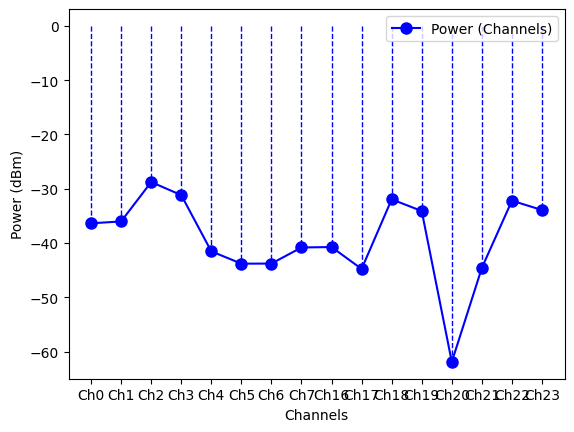

In [67]:
V_mean       = [None] * (N)
I_mean       = [None] * (N)
P_W_mean     = [None] * (N)
P_dBm_mean   = [None] * (N)


V, I = get_measurements(channels_list, sampling_rate, n_sample)

for ch_index in range(len(V)):
    V_mean[ch_index]     = np.mean(V[ch_index])                      # mean voltage
    I_mean[ch_index]     = np.mean(I[ch_index])                      # mean current
    P_W_mean[ch_index]   = V_mean[ch_index] * I_mean[ch_index]       # W
    P_dBm_mean[ch_index] = 10 * np.log10(P_W_mean[ch_index] / 0.001) # dBm


# Create a list of channel labels
channel_labels = [f'Ch{i}' for i in range(len(V)-8)]
channel_labels.extend(['Ch16', 'Ch17','Ch18','Ch19','Ch20','Ch21','Ch22','Ch23'])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data points for Channels1 as blue markers with channel labels on the x-axis
ax.plot(P_dBm_mean, 'bo-', label="Power (Channels)", markersize=8, linestyle=None)

# Set the x-axis ticks to match the number of labels
ax.set_xticks(range(len(channel_labels)))

# Set the x-axis labels
ax.set_xticklabels(channel_labels)

# Draw vertical lines connecting the data points to the X-axis
for x, y in enumerate(P_dBm_mean):
    ax.vlines(x, 0, y, colors='b', linestyles='dashed', linewidth=1)

# Set labels and legend
ax.set_xlabel("Channels")
ax.set_ylabel("Power (dBm)")
ax.legend()
plt.show()




### <span style="background-color: white; padding: 10px;"><font color='black'>Individual measurements.</font></span>


In [68]:
def sweep_collect_ports(phase_shifter_port, 
                        channels_list, 
                        sampling_rate,
                        n_sample,
                        decision,
                        v_max=None, 
                        i_max=None,
                        step_iv=None,
                        phase_shifter_set=None,
                        q=None):
    """
    sweep_voltage_collect_ports: This function acquires the voltage and current of the specified output 
    ports of the NiDAQ.

    Parameters:
    - phase_shifter_port: The number associated with the phase shifter to be tuned.
    - channels_list: A list of integers related to the NIDAQ outputs to be read. For example, if the list is [1, 2, 6], 
                        the channels to be added to the Nidaq Task would be "Dev1/ai1:2" and "Dev1/ai6". This is taken 
                        care of in get_measurements.
    - sampling_rate: The sampling rate for data acquisition.
    - n_sample: The number of samples to acquire.
    - decision: A flag (0 or 1) to determine whether to set voltage (0) or current (1).
    - v_max: The maximum voltage to be tuned to (used for sweeping).
    - i_max: Maximum current (currently not used in the function).
    - step_iv: The step size for sweeping.
    - phase_shifter_set: A list of phase shifters that represent the states of MZIs (e.g., bar or cross state). 
                            If None, all MZIs have a random phase shift.
    """
    V = []  # Initialize V as an empty list
    I = []  # Initialize I as an empty list


    # Connected to COM3
    serial_port_name = "COM3"
    # Setup Qontroller
    q = qontrol.QXOutput(serial_port_name=serial_port_name, response_timeout=0.1)   
    q.vmax = 12 
    # Initialize all ports to 0
    if decision == 0:
        q.v[:] = 0  # Set all voltages to 0
        N_STEP = int(v_max / step_iv)
    elif decision == 1:
        q.i[:] = 0  # Set all currents to 0
        N_STEP = int(i_max / step_iv)
    else:
        print('Current or Voltage setting not valid for sweep.')
        return None  # Return None without closing the device
    
    if phase_shifter_set is not None:
        pass
    
    if decision == 0 :
        print(f"The sweep goes from {0} to {v_max} with {N_STEP} steps.")
        vvals = [float(x) for x in np.linspace(0, v_max, N_STEP)]
        for val in vvals:
                q.v[phase_shifter_port] = val  # Set voltage if decision is 0
                time.sleep(0.05)
                print(val)
                print(f"Voltage {q.v[phase_shifter_port]} Current {q.i[phase_shifter_port]}")
    else :
        print(f"The sweep goes from {0} to {i_max} with {N_STEP} steps.")
        ivals = [float(x) for x in np.linspace(0, i_max, N_STEP)]
        for val in ivals:
            q.i[phase_shifter_port] = val  # Set current if decision is 1
            time.sleep(0.1)
            print(q.v[phase_shifter_port],q.i[phase_shifter_port])
            print(f"Voltage {q.v[phase_shifter_port]} Current {q.i[phase_shifter_port]}")
            
            # Returns the Vs and Is channels [1] and [2] - Raw values
            V_raw, I_raw = get_measurements(channels_list, sampling_rate, n_sample)
            
            V.append(V_raw)  # Append V_raw to the list V
            I.append(I_raw)  # Append I_raw to the list I
            time.sleep(0.05)
            
    set_voltage = q.v[phase_shifter_port]
    set_current = q.i[phase_shifter_port]
    
    print(f"The {'Voltage' if decision == 0 else 'Current'} is {set_voltage if decision == 0 else set_current} {'V' if decision == 0 else 'A'}")
    # Ensure that the device is closed, whether an exception occurred or not
    if decision == 0:
        q.v[:] = 0  # Set all voltages back to 0
    elif decision == 1:
        q.i[:] = 0  # Set all currents back to 0
    print("Sweep complete.")
    
    q.close()

    return (V, I)


In [69]:
# general parameters
phase_shifter_port  = 64
channels_list = [0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23]
# voltage
v_max = 7
v_step = 0.1
# current
i_max = 7
step_iv = 0.5

# Data = sweep_collect_ports(phase_shifter_port, 
#                                    channels_list, 
#                                    sampling_rate,
#                                    n_sample,
#                                    decision, 
#                                    v_max, 
#                                    i_max,
#                                    step_iv,
#                                    None)
# V_raw = Data[0]
# I_raw = Data[1]

In [70]:
D = read_pkls_in_current_directory(".data\\mzm_tunning")

In [71]:
def mzi1_unitary(theta, phi, alpha, beta):
    """
    This represents the theoretical function of an MZI with two beam splitters
    and two phase shifters
    ---Phi--\       /--Theta--\      /----
    .        =alpha=           =beta=
    --------/       \---------/      \----
    """
    a = np.exp( 1j*phi )*( np.cos( alpha - beta )*np.sin( theta/2 ) + 1j*np.sin(alpha + beta)*np.cos( theta/2 ) )
    b =                    np.cos( alpha + beta )*np.cos( theta/2 ) + 1j*np.sin(alpha - beta)*np.sin( theta/2 )
    c = np.exp( 1j*phi )*( np.cos( alpha + beta )*np.cos( theta/2 ) - 1j*np.sin(alpha - beta)*np.sin( theta/2 ) )
    d =                  - np.cos( alpha - beta )*np.sin( theta/2 ) + 1j*np.sin(alpha + beta)*np.cos( theta/2 )
    return 1j*np.exp(1j*theta/2)*(np.array([[a, b], [c, d]]))

### <span style="background-color: white; padding: 10px;"><font color='black'>Test code..</font></span>


In [72]:
import qontrol
import sys
import time

# general parameters
phase_shifter_port  = 64
channels_list = [0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23]
# voltage
v_max = 7
v_step = 0.1
# current
i_max = 7
step_iv = 0.5

# Setup Qontroller
# serial_port_name = "/dev/tty.usbserial-FT31EUVZ"
serial_port_name = "COM3"
q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)
q.vmax = 12
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )

V_raw = []
I_raw = []
V = []
I = []

print("Would you like to proceed? (y/n)")
ch = 62
value_in = "Y"
ground_list = [0,1,2,3,4,5,6,47,48,49,50,51,52,53,54,95]
N_STEP = int(i_max/step_iv)
ivals = list(np.arange(0, i_max, step_iv))
for iv in ivals:
    V_raw = []
    I_raw = []
    q.i[ch] = float(iv)
    time.sleep(0.1)
    print('Current :',q.i[ch],'Voltage', q.v[ch])
    time.sleep(0.05)
    # Returns the Vs and Is channels [1] and [2] - Raw values
    V_raw, I_raw = get_measurements(channels_list, sampling_rate, n_sample)
    V.append(V_raw)  # Append V_raw to the list V
    I.append(I_raw)  # Append I_raw to the list I
    time.sleep(0.05)
q.i[ch] = 0
q.close()


Driver thresholds set @ 12 V , 20 mA
QXOutput.__setattr__: Warning: Overwriting of 'vmax' is forbidden.
Qontroller 'Q8iv-00B1' initialised with firmware v2.3.7 and 96 channels
Would you like to proceed? (y/n)
Current : -0.002 Voltage 0.0003
Current : 0.5118 Voltage 0.2513
Current : 1.0156 Voltage 0.5155
Current : 1.5218 Voltage 0.7769
Current : 2.0264 Voltage 1.0341
Current : 2.5308 Voltage 1.2869
Current : 3.0366 Voltage 1.5368
Current : 3.5419 Voltage 1.7839
Current : 4.0457 Voltage 2.0284
Current : 4.5515 Voltage 2.2717
Current : 5.0399 Voltage 2.4983
Current : 5.544 Voltage 2.739
Current : 6.05 Voltage 2.9795
Current : 6.5559 Voltage 3.2198


In [73]:
import importlib
importlib.reload(func)

<module 'functions' from 'c:\\Users\\QPG\\Downloads\\Marseille\\Marseille\\functions.py'>

In [77]:
i_max = 12
V,I = func.sweep_current_collect_ports(ch,channels_list,sampling_rate,n_sample,i_max,step_iv)

Driver thresholds set @ 12 V , 20 mA
QXOutput.__setattr__: Warning: Overwriting of 'vmax' is forbidden.
The sweep goes from 0 to 12 with 24 steps.
Voltage 0.0003 Current -0.0025
Voltage 0.1351 Current 0.5333
Voltage 0.2627 Current 1.0598
Voltage 0.8107 Current 1.5877
Voltage 1.0779 Current 2.113
Voltage 1.078 Current 2.641
Voltage 1.6019 Current 3.1689
Voltage 1.6019 Current 3.6943
Voltage 1.8584 Current 4.2211
Voltage 2.1132 Current 4.7323
Voltage 2.6033 Current 5.2593
Voltage 2.6033 Current 5.786
Voltage 3.105 Current 6.3129
Voltage 3.234 Current 6.8395
Voltage 3.6059 Current 7.3666
Voltage 3.6191 Current 7.894
Voltage 4.1077 Current 8.4193
Voltage 4.3596 Current 8.9454
Voltage 4.3596 Current 9.4724
Voltage 4.6131 Current 9.9992
Voltage 5.1224 Current 10.5244
Voltage 5.3793 Current 11.0509
Voltage 5.6376 Current 11.5764
Voltage 5.7556 Current 12.1037
The Voltage is 12.1031 V
Sweep complete.


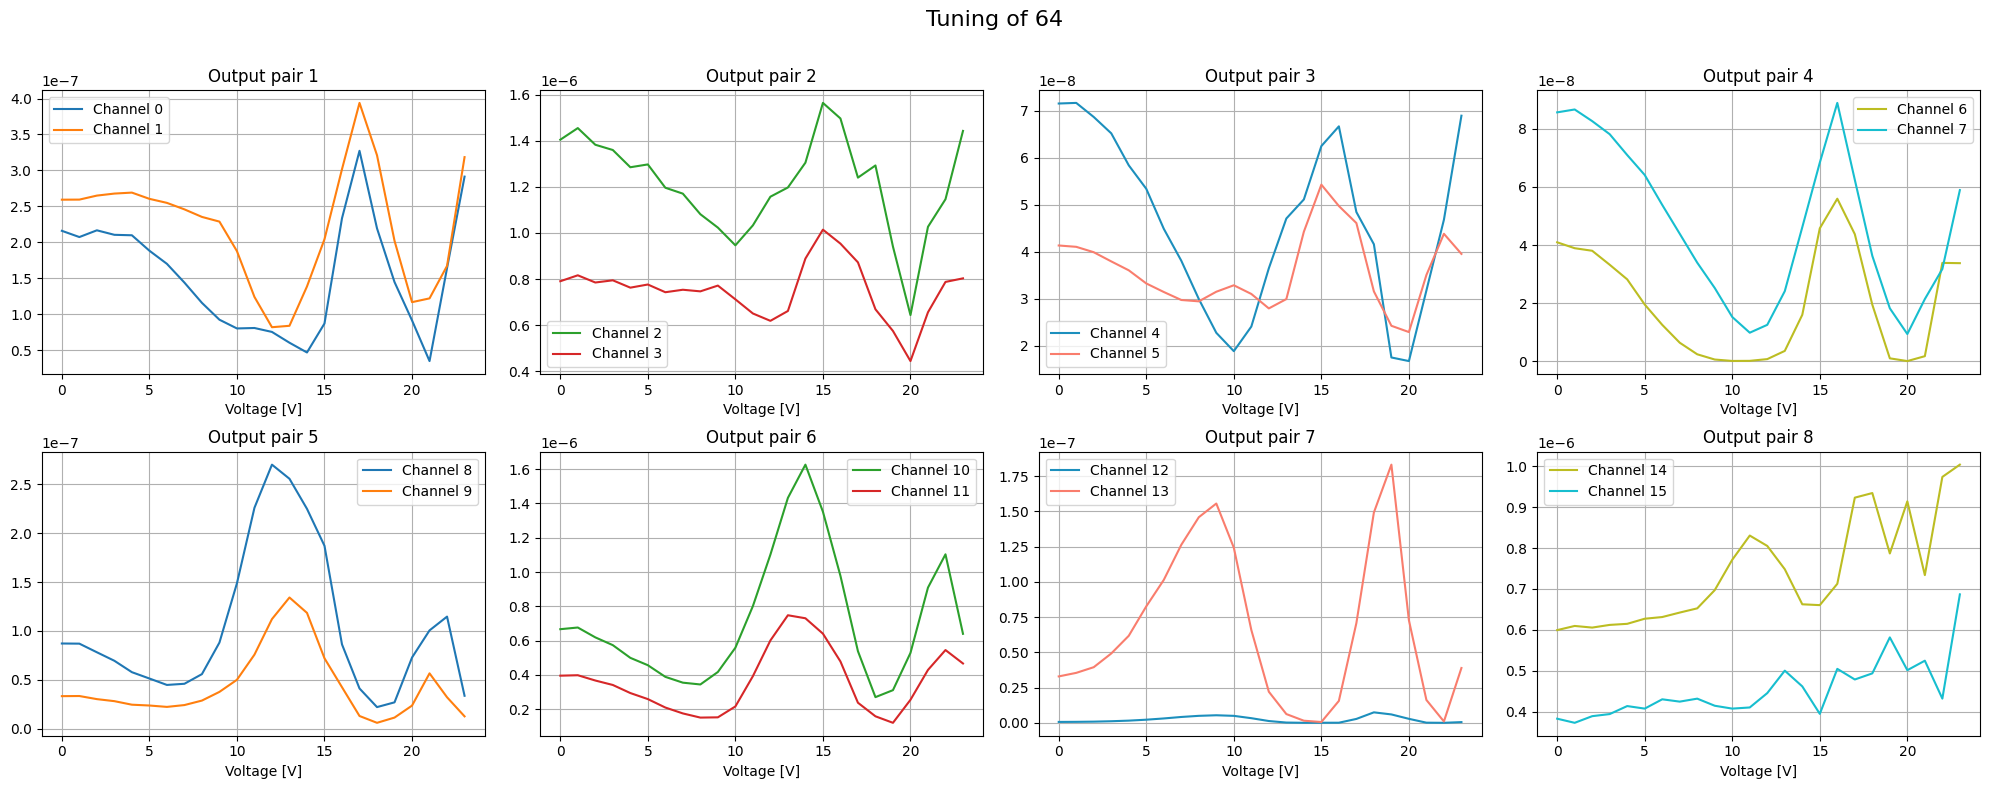

In [80]:
V_raw,I_raw = arrange_data_V_I(V,I)
P = func.to_mean_power(V_raw,I_raw)
voltage = np.arange(0, v_max, v_step)
current = np.arange(0, i_max, step_iv)
plot_channels(P, ivals, phase_shifter_port)

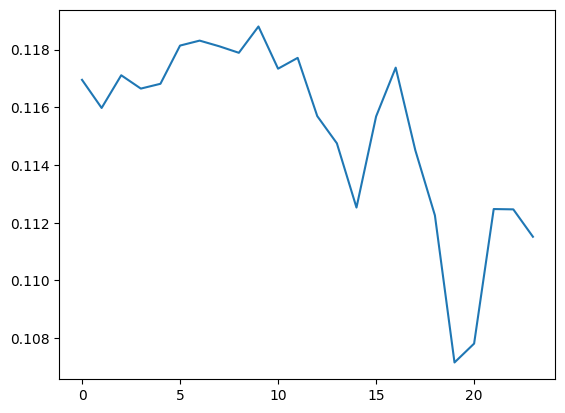

In [76]:
V_mean, I_mean = to_mean_voltage_current(V_raw,I_raw)
V_sum = np.array(V_mean).sum(axis = 0)
plt.plot(V_sum)
plt.show()